In [1]:
import numpy as np
import json
import cvxpy as cp
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

(CVXPY) Apr 11 03:55:43 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 11 03:55:43 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
sns.set_style("whitegrid")
np.random.seed(2)

In [3]:
with open("amazon_predictions.npy", "rb") as f:
    REL_MATRIX = np.load(f)

with open("amazon_user_groups.json", "r") as f:
    GROUPS_MAP = json.load(f)

In [4]:
ALPHA = 0.95
WEIGHTS_IDX = 1
RHO_IDX = 0
GAMMA_POINTS = [0, 0.35, 0.7, 1]
GROUPS = ["top_category"]
N_RUNS = 5
N_CONSUMERS = 500
N_PRODUCERS = 200
K_REC = 10

In [7]:
def sample_utility(m, n, sample_m, sample_n, W):
    rng = np.random.default_rng()

    users = rng.choice(m, size=sample_m, replace=False)
    items = rng.choice(n, size=sample_n, replace=False)
    return W[users][:, items]


def sample_candidate_items(rel_matrix_users: np.ndarray, n_candidates: int) -> np.ndarray:
    top_items = np.argsort(rel_matrix_users, axis=1)[:, -n_candidates:]
    unique_items = np.unique(top_items)
    return rel_matrix_users[np.arange(rel_matrix_users.shape[0])[:, None], unique_items]


def _parse_groups_ids(consumer_ids, groups_map: list[dict[str, int]], group_key: str):
    """Parses given group key value to int for each consumer"""

    consumer_groups = [i[group_key] for i in groups_map if i["user_id"] in consumer_ids]
    all_groups = list(set(consumer_groups))

    return np.array([all_groups.index(i) for i in consumer_groups])

def sample_users_from_groups(
    users_count: int,
    items_count: int,
    groups_map: dict[int, str],
    group_key: str,
    data: np.ndarray,
    naive_sampling: bool = True,
) -> tuple[np.ndarray, list[int], list[int]]:
    users_per_group = {
        group: max(round(users_count * count / len(groups_map)), 1)
        for group, count in Counter([i[group_key] for i in groups_map]).items()
    }
    group_users = defaultdict(list)
    for row in groups_map:
        group_users[row[group_key]].append(row["user_id"])

    sampled_users = []
    for group, users in group_users.items():
        sampled_users.extend(np.random.choice(users, users_per_group[group], replace=False))

    group_assignments = _parse_groups_ids(sampled_users, groups_map, group_key)

    rng = np.random.default_rng()
    if naive_sampling:
        items = rng.choice(data.shape[1], size=items_count, replace=False)
        return data[sampled_users][:, items], sampled_users, group_assignments

    rel_matrix_sampled = data[sampled_users]
    top_items = sample_candidate_items(rel_matrix_sampled, items_count)


    return top_items, sampled_users, group_assignments


def compute_producer_optimal_solution(rel_matrix: np.ndarray, k_rec: int) -> cp.Problem:
    x_alloc = cp.Variable(rel_matrix.shape, boolean=True)

    # constraints
    constraints = [
        # recommend k items
        cp.sum(x_alloc, axis=1) == k_rec,
    ]

    # maximize the minimal item utility
    problem = cp.Problem(
        cp.Maximize(cp.min(cp.sum(x_alloc, axis=0))),
        constraints,
    )
    problem.solve(solver=cp.SCIP)

    return problem

def compute_consumer_optimal_solution(
    rel_matrix: np.ndarray,
    group_assignments: np.ndarray,
    k_rec: int,
    gamma: float,
    producer_max_min_utility,
    alpha: float = 0.95
) -> cp.Problem:
    # producer allocations
    x_alloc = cp.Variable(rel_matrix.shape, boolean=True)

    constraints = [
        # there should be k_rec producers allocated to consumer
        cp.sum(x_alloc, axis=1) == k_rec,
        # each producer should get at least gamma * optimal producer utility
        cp.sum(x_alloc, axis=0) >= gamma * producer_max_min_utility,
    ]


    # greedy producer allocations for consumer
    greedy_allocations = np.sort(rel_matrix, axis=1)[:, -k_rec:].sum(axis=1)

    # precomputing values for later processing
    unique_groups, group_indices = np.unique(group_assignments, return_inverse=True)
    num_groups = len(unique_groups)
    group_masks = [group_indices == i for i in range(num_groups)]
    group_sizes = np.array([mask.sum() for mask in group_masks])


    allocations = cp.sum(cp.multiply(rel_matrix, x_alloc), axis=1)
    # Compute normalized losses for all groups simultaneously (vectorized)
    normalized_losses = []
    for mask, size in zip(group_masks, group_sizes):
        group_alloc = allocations[mask]
        greedy_group_alloc = greedy_allocations[mask]

        # compute loss for each group
        normalized_loss = cp.sum(1 - (group_alloc / greedy_group_alloc)) / size
        normalized_losses.append(normalized_loss)

    # CVaR computation (vectorized)
    rho = cp.Variable(nonneg=True)
    cvar_objective = rho + (1 / ((1 - alpha) * num_groups)) * cp.sum(cp.pos(cp.hstack(normalized_losses) - rho))

    # Define and solve the optimization problem
    problem = cp.Problem(cp.Minimize(cvar_objective), constraints)
    problem.solve(solver=cp.SCIP)

    return problem


def compute_consumer_producer_utils_per_gamma(
    rel_matrix: np.ndarray, k_rec: int, gamma_points: list[float], group_assignments: list[int], alpha: float
) -> tuple[list[list[float]], list[list[float]]]:
    producer_max_min_utility = compute_producer_optimal_solution(rel_matrix, k_rec).value
    greedy_allocations_per_consumer = np.sort(rel_matrix, axis=1)[:, -k_rec:].sum(axis=1)

    consumers_utils = []
    producers_utils = []

    for gamma in gamma_points:
        print("Computing alloactions for gamma:", gamma)
        v_user_result = compute_consumer_optimal_solution(
            rel_matrix,
            group_assignments,
            k_rec,
            gamma,
            producer_max_min_utility,
            alpha=alpha,

        )
        producer_assignments = v_user_result.variables()[WEIGHTS_IDX].value
        consumers_utils.append(
            (rel_matrix * producer_assignments).sum(axis=1) / greedy_allocations_per_consumer
        )
        producers_utils.append(producer_assignments.sum(axis=0))

    return consumers_utils, producers_utils


def compute_consumer_producer_utils_per_gamma_for_groups(
    rel_matrix: np.ndarray,
    n_consumers: int,
    n_producers: int,
    k_rec: int,
    n_runs: int,
    gamma_points: list[float],
    groups_map: list[dict[str, int]],
    group_key: str,
    alpha: float,
    naive_sampling: bool = True,
) -> tuple[np.ndarray, list[int], list[float]]:
    consumers_ids = []
    consumers_utils = []
    for _ in tqdm(range(n_runs)):
        rel_matrix_sampled, consumer_ids_sampled, group_assignments = sample_users_from_groups(
            n_consumers, n_producers, groups_map, group_key, rel_matrix, naive_sampling
        )
        consumer_utils_run, _ = compute_consumer_producer_utils_per_gamma(rel_matrix_sampled, k_rec, gamma_points, group_assignments, alpha)

        consumers_ids.append(consumer_ids_sampled)
        consumers_utils.append(consumer_utils_run)

    return consumers_ids, consumers_utils

In [8]:
def parse_results(
    consumers_ids: list[list[int]],
    consumers_utils: list[list[int]],
    n_runs: int,
    gamma_points: list[float],
):
    distinct_groups = {row[group] for row in GROUPS_MAP if row["user_id"] in users_ids[0]}
    results = defaultdict(lambda: defaultdict(list))

    for group in distinct_groups:
        for gamma_id, gamma in enumerate(gamma_points):
            for run_id in range(n_runs):
                run_consumers_ids = consumers_ids[run_id]
                run_consumer_groups = np.array([i[group] for i in GROUPS_MAP if i["user_id"] in run_consumers_ids])
                run_consumer_groups_idx = np.where(run_consumer_groups == group)[0]
                run_consumers_utils = consumers_utils[run_id]
                results[group][gamma].append(run_consumers_utils[gamma_id][run_consumer_groups_idx].mean())

    consumer_utils_mean = np.mean(consumers_utils, axis=2).mean(axis=0)

    return results, consumer_utils_mean


def plot_groups_results(results: dict, consumer_utils_mean: np.ndarray, save_path: str) -> None:
    plt.figure(figsize=(10,6), dpi=300)
    sns.set_palette(sns.color_palette("husl", len(group_names)))
    # sort results by group name
    for group in results.items():
        group_name, _gammas = group
        gamma_means = {}
        gamma_std_err = {}
        for gamma, runs in _gammas.items():
            gamma_means[gamma] = np.mean(runs)
            gamma_std_err[gamma] = np.std(runs) / np.sqrt(N_RUNS)


        plt.plot(
            list(gamma_means.keys()),
            list(gamma_means.values()),
            label=f"{group_name.capitalize()}",
        )
        plt.fill_between(
            list(gamma_std_err.keys()),
            np.array(list(gamma_means.values())) - np.array(list(gamma_std_err.values())),
            np.array(list(gamma_means.values())) + np.array(list(gamma_std_err.values())),
            alpha=0.1,
        )

    plt.ylabel('Normalized consumer utility')
    plt.title(f"Consumer and producer utility tradeoff for retrieving k=10 items ({group_name.replace("group", "").replace('_', ' ')} group)")
    plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
    plt.plot(GAMMA_POINTS, np.mean(consumer_utils_mean, axis=2).mean(axis=0), color="black", label="Mean user utility", linestyle="--")
    plt.legend()
    plt.savefig(f"{save_path}/tradeoff_curve_group_{group_name}_n_consumers_{N_CONSUMERS}_n_producers_{N_PRODUCERS}_n_runs_{N_RUNS}_top_k_{TOP_K}_alpha_{ALPHA}.png")

for group in GROUPS:
    group_names = sorted({i[group] for i in GROUPS_MAP})

    consumers_ids, consumers_utils = compute_consumer_producer_utils_per_gamma_for_groups(
        rel_matrix=REL_MATRIX,
        n_consumers=N_CONSUMERS,
        n_producers=N_PRODUCERS,
        n_runs=N_RUNS,
        gamma_points=GAMMA_POINTS,
        k_rec=K_REC,
        groups_map=GROUPS_MAP,
        group_key=group,
        alpha=ALPHA
    )
    results, consumer_utils_mean = parse_results(consumers_ids, consumers_utils, N_RUNS, GAMMA_POINTS)
    plot_groups_results(results, consumer_utils_mean, "./media23")

  0%|          | 0/5 [00:00<?, ?it/s]

Computing alloactions for gamma: 0
Computing alloactions for gamma: 0.35
pressed CTRL-C 1 times (5 times for forcing termination)


  0%|          | 0/5 [43:09<?, ?it/s]


SolverError: Solver 'SCIP' failed. Try another solver, or solve with verbose=True for more information.

<>:34: SyntaxWarning: invalid escape sequence '\g'
<>:34: SyntaxWarning: invalid escape sequence '\g'
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_2005/3317059559.py:34: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"$\gamma$ = {gamma}", fontdict={"fontsize": 12})
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_2005/3317059559.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_2005/3317059559.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_2005/3317059559.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed '

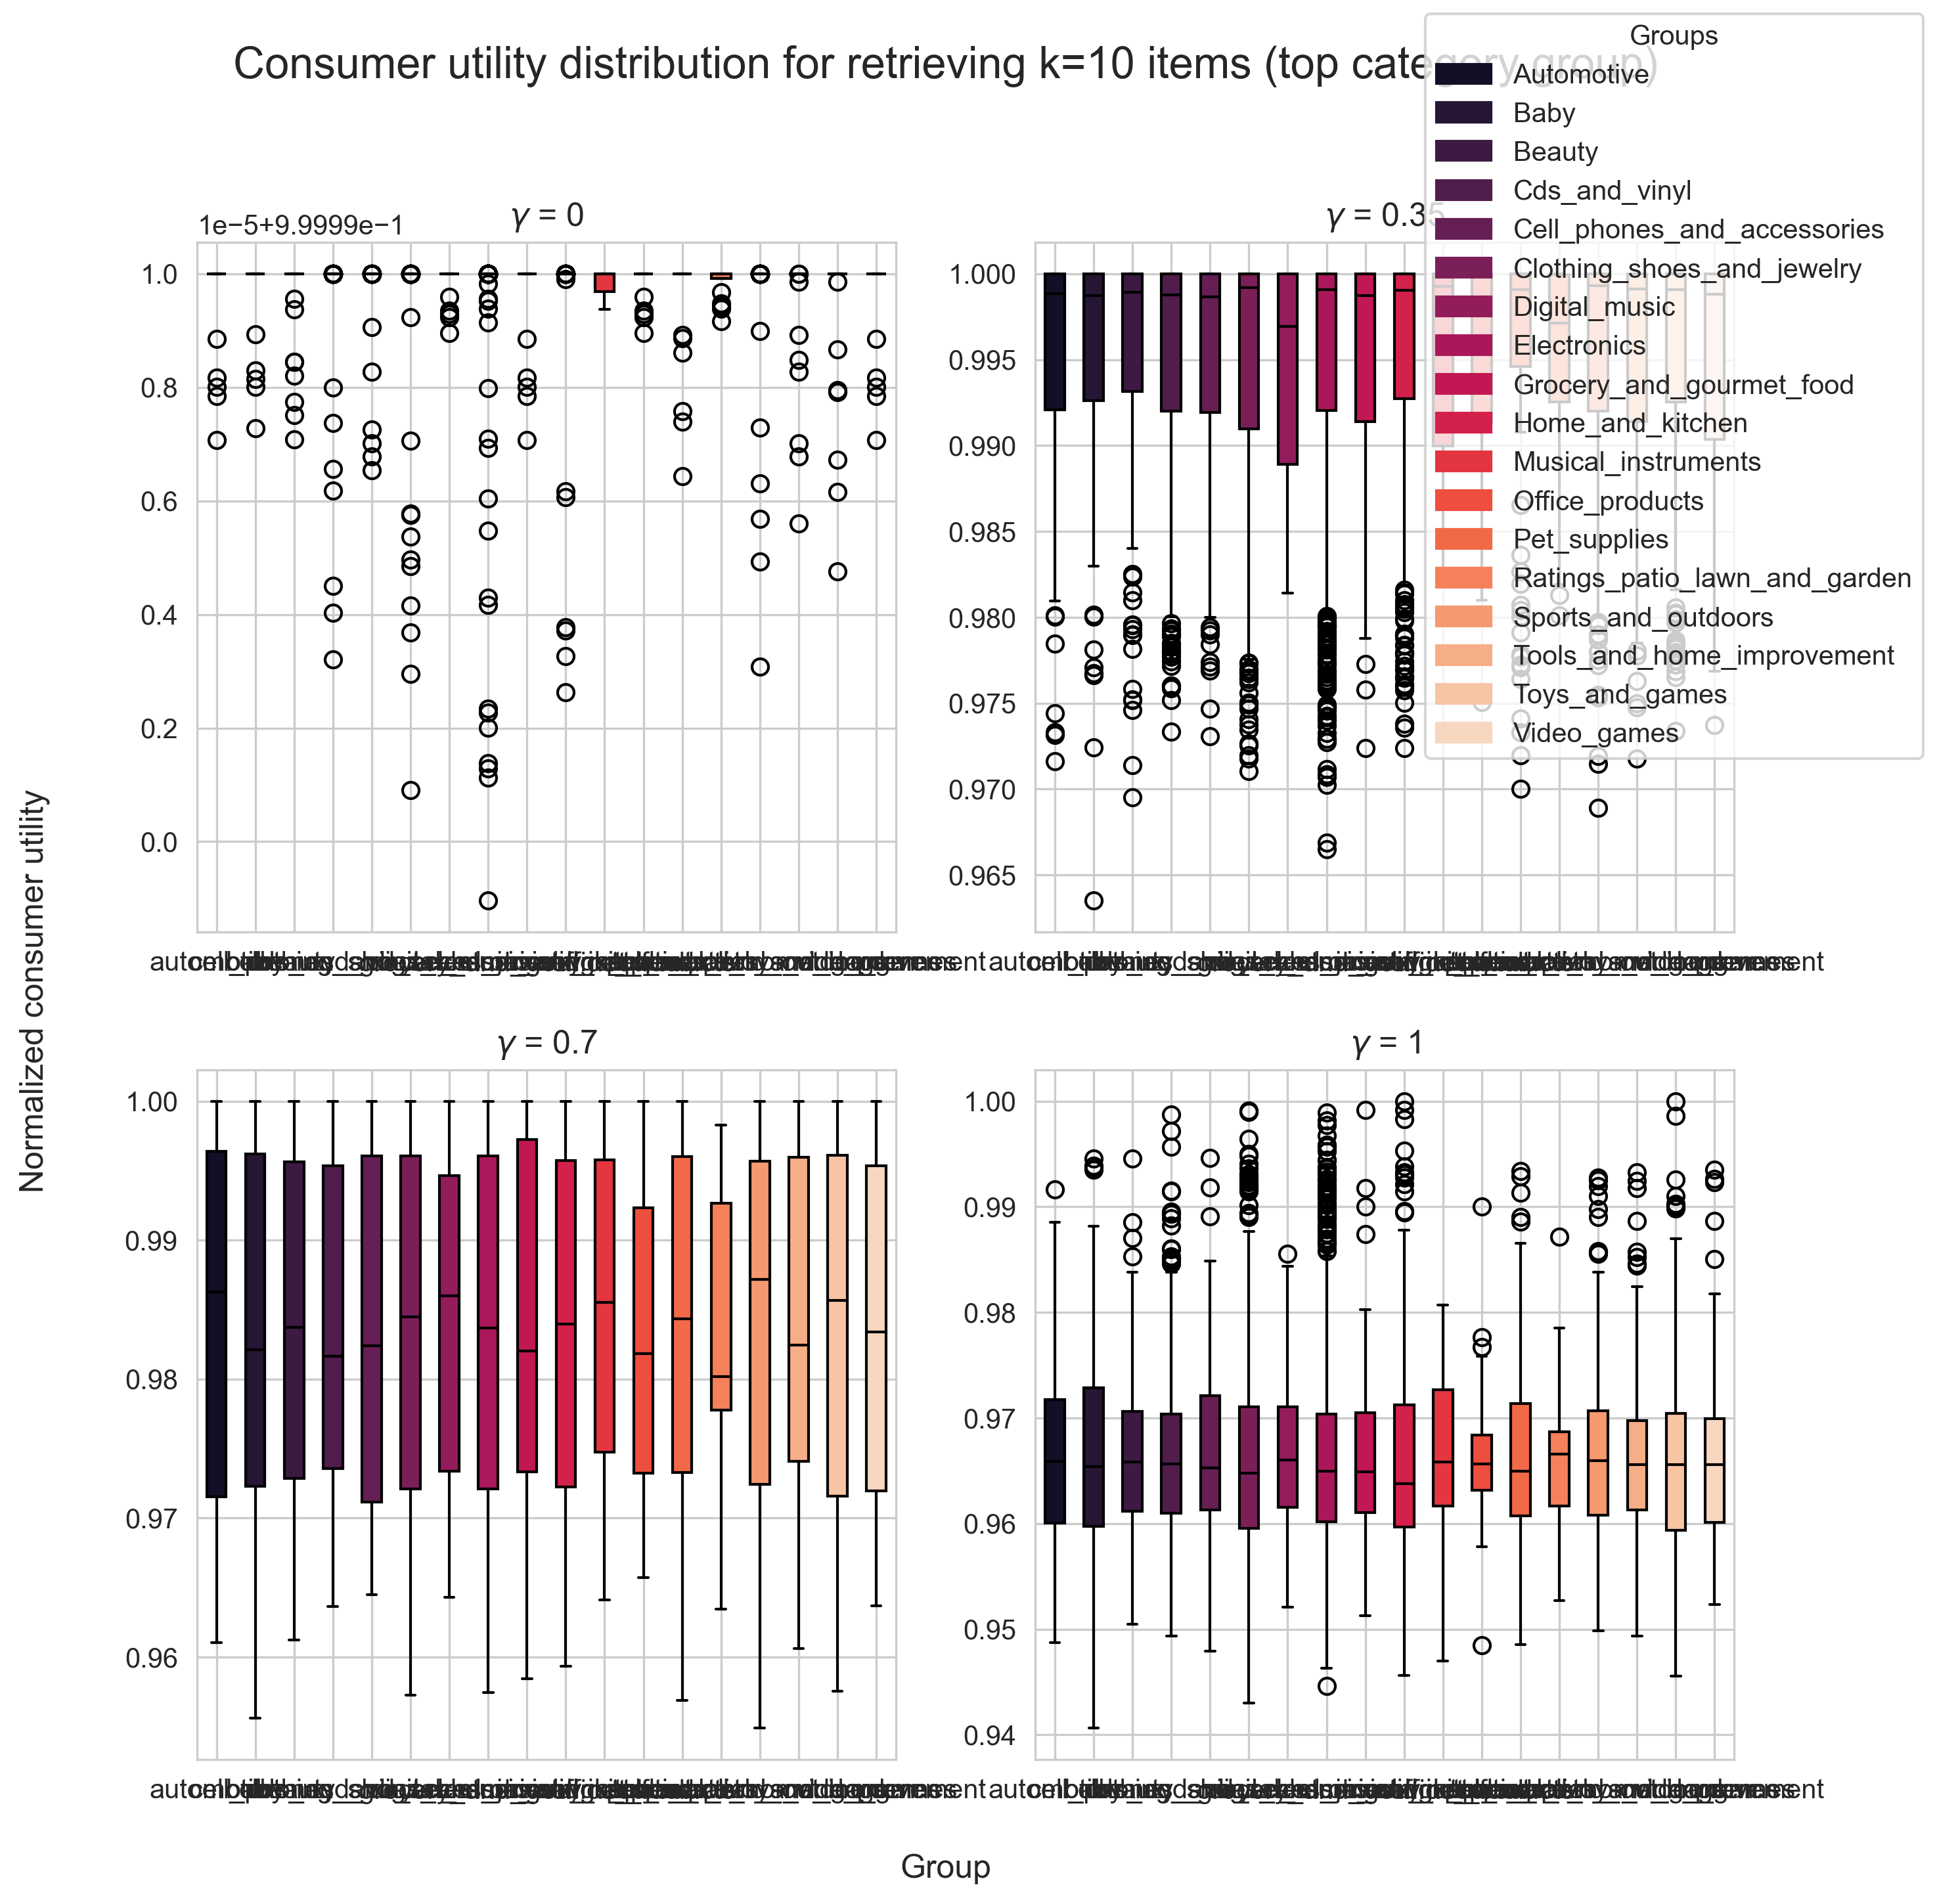

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


def display_group_boxplots(type, user_ids, user_utils, user_groups, gammas, group_name, top_k, output_path):
    n_runs = len(user_ids)
    users_size = len(user_ids[0])
    items_size = len(user_utils[0][0])

    results = defaultdict(dict)

    groups = [row[group_name] for row in user_groups if row["user_id"] in users_ids[0]]

    results = defaultdict(lambda: defaultdict(list))

    for gamma_id, gamma in enumerate(gammas):
        for group in set(groups):
            for run_id in range(n_runs):
                run_user_ids = users_ids[run_id]
                run_user_groups = np.array([i[group_name] for i in user_groups if i["user_id"] in run_user_ids])
                run_user_groups_idx = np.where(run_user_groups == group)[0]
                run_user_utils = user_utils[run_id]
                results[gamma][group].extend(run_user_utils[gamma_id][run_user_groups_idx])

    all_groups = sorted(set(k for gamma in results.values() for k in gamma))
    colors = sns.color_palette("rocket", len(all_groups))
    color_map = dict(zip(all_groups, colors))

    plt.figure(figsize=(10, 10), dpi=300)
    # Plot each gamma
    for gamma_id, (gamma, _groups) in enumerate(results.items()):
        _ = plt.subplot(2, 2, gamma_id + 1)
        plt.title(f"$\gamma$ = {gamma}", fontdict={"fontsize": 12})

        # Sort groups for consistent order and plot
        _groups = {k: _groups[k] for k in sorted(_groups.keys())}
        box_plot_data = list(_groups.values())
        box = plt.boxplot(
            box_plot_data,
            labels=list(_groups.keys()),
            #showfliers=False,
            patch_artist=True,
            medianprops=dict(color='black'),  # Add black median line
        )

        # Apply consistent colors
        for patch, label in zip(box['boxes'], _groups.keys()):
            patch.set_facecolor(color_map[label])


    # Adjust subplot parameters to give space for axis labels
    plt.subplots_adjust(left=0.12, bottom=0.11)

    # Set unified axis labels for the entire figure
    plt.figtext(0.5, 0.05, "Group", ha="center", fontsize=12)
    plt.figtext(0.03, 0.5, "Normalized consumer utility", va="center", rotation="vertical", fontsize=12)

    # Create legend
    legend_handles = [mpatches.Patch(color=color_map[group], label=group.capitalize()) for group in all_groups]
    plt.figlegend(handles=legend_handles, loc='upper right', title='Groups')
    # add global title
    plt.suptitle(f"Consumer utility distribution for retrieving k=10 items ({group_name.replace('group', '').replace('_', ' ')} group)", fontsize=16)

    output_path = output_path + f"{type}_consumer_utility_boxplots_{group_name}_user_size_{users_size}_items_{items_size}_n_draws_{n_runs}_top_k_{top_k}.pdf"

    #plt.savefig(output_path)
    plt.show()

display_group_boxplots("cvar", users_ids, u_utils, user_groups, gamma_points, "top_category", top_k, "./media22/")

In [9]:
import cvxpy as cp

print(type(cp.SCIP))

<class 'str'>
